In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import h5py
import shap

In [2]:
print("h5py version:", h5py.__version__)
print("SHAP version:", shap.__version__)
print("PyTorch version:", torch.__version__)

h5py version: 3.11.0
SHAP version: 0.39.0
PyTorch version: 2.3.1


In [3]:
params = {'batch_size': 128,
          'epochs': 100,
          'early_stop': 10,
          'lr': 0.002,
          'n_conv_layer': 4,
          'num_filters1': 256,
          'num_filters2': 60,
          'num_filters3': 60, 
          'num_filters4': 120,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'n_dense_layer': 2,
          'dense_neurons1': 256,
          'dense_neurons2': 256,
          'dropout_conv': 'no',
          'dropout_prob': 0.4,
          'pad':'same'}

In [4]:
import pytorch_lightning as pl
from torch import nn

In [5]:
class DeepSTARR(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        
        self.params = params

        self.avgpool = nn.AvgPool1d(2)
        self.conv_dropout = nn.Dropout(p=0.1)
    
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv1d(4, 256, kernel_size=7, padding=params['pad']),
            nn.BatchNorm1d(256),
            nn.LeakyReLU()
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv1d(256, 64, kernel_size=3, padding=params['pad'], dilation=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        # Third convolutional layer
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=5, padding=params['pad'], dilation=4),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        # Four convolutional layer
        self.conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=params['pad'], dilation=8),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=params['pad'], dilation=16),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        
        # Fully connected layers
        fc_layers = []
        in_features = self._get_conv_output_shape((1, 4, 1001))
        for i in range(params['n_dense_layer']):
            out_features = params['dense_neurons'+str(i+1)]
            fc_layers.append(nn.Linear(in_features, out_features))
            fc_layers.append(nn.BatchNorm1d(out_features))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(params['dropout_prob']))
            in_features = out_features
        
        fc_layers.append(nn.Linear(in_features, 1))  # Final output layer
        self.fc = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + self.conv3(x)
        x = self.conv_dropout(x)
        x = x + self.conv4(x)
        x = self.conv_dropout(x)
        x = self.avgpool(x)
        x = x + self.conv5(x)
        x = self.avgpool(x)
            
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        
        return x

    def _get_conv_output_shape(self, shape):
        x = torch.rand(*shape)
        
        # mimic the convolution forward part
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = self.conv5(x)
        x = self.avgpool(x)
            
        return x.data.view(1, -1).size(1)
    
    def predict(self, x):
        return self.forward(x)

In [6]:
model_mesoderm_path = './checkpoints/Residual_dilated_DeepSTARR_mesoderm.ckpt' # best model
model_visceral_path = './checkpoints/Residual_dilated_DeepSTARR_visceral.ckpt' # best model
model_cardiac_path = './checkpoints/Residual_dilated_DeepSTARR_cardiac.ckpt' # best model
model_somatic_path = './checkpoints/Residual_dilated_DeepSTARR_somatic.ckpt' # best model
model_mesoderm = DeepSTARR.load_from_checkpoint(model_mesoderm_path, params=params).cpu()
model_visceral = DeepSTARR.load_from_checkpoint(model_visceral_path, params=params).cpu()
model_cardiac = DeepSTARR.load_from_checkpoint(model_cardiac_path, params=params).cpu()
model_somatic = DeepSTARR.load_from_checkpoint(model_somatic_path, params=params).cpu()
model_mesoderm.eval()
model_visceral.eval()
model_cardiac.eval()
model_somatic.eval()

DeepSTARR(
  (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv_dropout): Dropout(p=0.1, inplace=False)
  (conv1): Sequential(
    (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(8,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=Tr

In [7]:
X_test = joblib.load('./data/test/X_test')

In [8]:
np.random.seed(seed=1234)
# background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)].astype(np.float32).transpose(0, 2, 1)
background = X_test[np.random.choice(X_test.shape[0], 500, replace=False)].astype(np.float32).transpose(0, 2, 1)
background = torch.tensor(background)
del X_test

In [9]:
explainer_score_mesoderm = shap.DeepExplainer(model_mesoderm, background)
explainer_score_visceral = shap.DeepExplainer(model_visceral, background)
explainer_score_cardiac = shap.DeepExplainer(model_cardiac, background)
explainer_score_somatic = shap.DeepExplainer(model_somatic, background)

In [10]:
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_meso')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_visc')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_card')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_soma')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_meso')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_visc')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_card')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_soma')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_meso')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_visc')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_card')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_soma')
# cand_test_data = joblib.load('./data/sequences_strongest_diff/diff_data_meso')
# cand_test_data = joblib.load('./data/sequences_strongest_diff/diff_data_visc')
# cand_test_data = joblib.load('./data/sequences_strongest_diff/diff_data_card')
cand_test_data = joblib.load('./data/sequences_strongest_diff/diff_data_soma')

# sort by strength to have the stongest on top for later plotting
# cand_test_data = cand_test_data.sort_values(by='S2_mesoderm_log2', ascending = False)
# cand_test_data = cand_test_data.sort_values(by='S2_visceral_log2', ascending = False)
# cand_test_data = cand_test_data.sort_values(by='S2_cardiac_log2', ascending = False)
# cand_test_data = cand_test_data.sort_values(by='S2_somatic_log2', ascending = False)
print(len(cand_test_data))
cand_test_data.head(20)

1


,seqnames,start,end,name,strand,S2_cardiac_log2,S2_fat_body_log2,S2_hemocytes_log2,S2_mesoderm_log2,S2_neuro_log2,S2_somatic_log2,S2_visceral_log2,Sequence,Class,split
100709,chr2R,19231201,19232201,chr2R_19231201_19232201,+,4.18589,3.277951,4.817071,4.022608,4.767528,6.171229,4.749196,CAACTGAATGCCAATAACTGTACAACCAGCGAGTGGAAAACTATAC...,positive,fold_test


In [11]:
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns

# define a function to one-hot encode a single DNA sequence
def one_hot_encode(seq):
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# function to load sequences and enhancer activity
def prepare_input(data_set):

  # one-hot encode DNA sequences, apply function
  seq_matrix = np.array(data_set['Sequence'].apply(one_hot_encode).tolist())

  return seq_matrix

In [12]:
slice_cand_test_data = cand_test_data[:1] # pick the strongest one
slice_X_cand_test = prepare_input(slice_cand_test_data) 
slice_X_cand_test = slice_X_cand_test.astype(np.float32).transpose(0, 2, 1)
slice_X_cand_test = torch.tensor(slice_X_cand_test)
print(slice_X_cand_test.shape)

slice_pred_values_mesoderm = model_mesoderm.predict(slice_X_cand_test)
slice_pred_values_visceral = model_visceral.predict(slice_X_cand_test)
slice_pred_values_cardiac = model_cardiac.predict(slice_X_cand_test)
slice_pred_values_somatic = model_somatic.predict(slice_X_cand_test)
print(slice_pred_values_mesoderm.shape)
print(slice_pred_values_visceral.shape)
print(slice_pred_values_cardiac.shape)
print(slice_pred_values_somatic.shape)

torch.Size([1, 4, 1001])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


In [13]:
slice_shap_values_mesoderm = explainer_score_mesoderm.shap_values(slice_X_cand_test).transpose(0, 2, 1)
slice_shap_values_visceral = explainer_score_visceral.shap_values(slice_X_cand_test).transpose(0, 2, 1)
slice_shap_values_cardiac = explainer_score_cardiac.shap_values(slice_X_cand_test).transpose(0, 2, 1)
slice_shap_values_somatic = explainer_score_somatic.shap_values(slice_X_cand_test).transpose(0, 2, 1)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [14]:
slice_X_cand_test = slice_X_cand_test.numpy().transpose(0, 2, 1)

In [15]:
print(slice_X_cand_test.shape)
print(slice_shap_values_mesoderm.shape)
print(slice_shap_values_visceral.shape)
print(slice_shap_values_cardiac.shape)
print(slice_shap_values_somatic.shape)

(1, 1001, 4)
(1, 1001, 4)
(1, 1001, 4)
(1, 1001, 4)
(1, 1001, 4)


In [16]:
slice_final_contr_scores_mesoderm = slice_shap_values_mesoderm * slice_X_cand_test
print(slice_final_contr_scores_mesoderm.shape)
print(slice_cand_test_data.iloc[0]['Sequence'][:6]) # check DNA sequence
print(slice_final_contr_scores_mesoderm[0,:6])

slice_final_contr_scores_visceral = slice_shap_values_visceral * slice_X_cand_test
print(slice_final_contr_scores_visceral.shape)
print(slice_cand_test_data.iloc[0]['Sequence'][:6]) # check DNA sequence
print(slice_final_contr_scores_visceral[0,:6])

slice_final_contr_scores_cardiac = slice_shap_values_cardiac * slice_X_cand_test
print(slice_final_contr_scores_cardiac.shape)
print(slice_cand_test_data.iloc[0]['Sequence'][:6]) # check DNA sequence
print(slice_final_contr_scores_cardiac[0,:6])

slice_final_contr_scores_somatic = slice_shap_values_somatic * slice_X_cand_test
print(slice_final_contr_scores_somatic.shape)
print(slice_cand_test_data.iloc[0]['Sequence'][:6]) # check DNA sequence
print(slice_final_contr_scores_somatic[0,:6])

(1, 1001, 4)
CAACTG
[[ 0.         -0.0008865  -0.         -0.        ]
 [-0.00277325 -0.         -0.         -0.        ]
 [-0.00080086 -0.          0.         -0.        ]
 [-0.         -0.00051292  0.         -0.        ]
 [-0.         -0.         -0.         -0.00267422]
 [-0.          0.         -0.00198641  0.        ]]
(1, 1001, 4)
CAACTG
[[-0.00000000e+00 -5.64321002e-04 -0.00000000e+00 -0.00000000e+00]
 [-9.36141820e-04 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 3.18834936e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  1.00659893e-03 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -5.73139964e-03]
 [-0.00000000e+00 -0.00000000e+00  3.75924938e-05 -0.00000000e+00]]
(1, 1001, 4)
CAACTG
[[-0.00000000e+00 -2.81945304e-05 -0.00000000e+00 -0.00000000e+00]
 [-1.20640208e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-7.47089274e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -6.24615350

In [17]:
import deeplift
from deeplift.visualization import viz_sequence # function from https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/deeplift/visualization/viz_sequence.py

name: chr2R_19231201_19232201
S2_mesoderm_log2: 4.02
Pred act: 4.53
Actual contribution scores


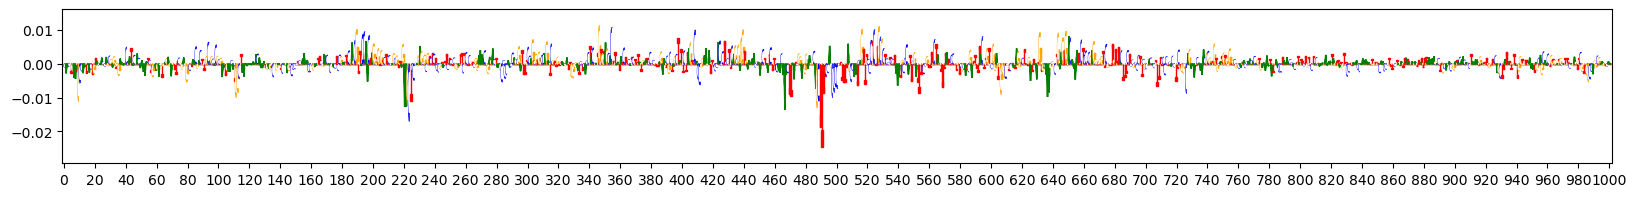

S2_visceral_log2: 4.75
Pred act: 5.02
Actual contribution scores


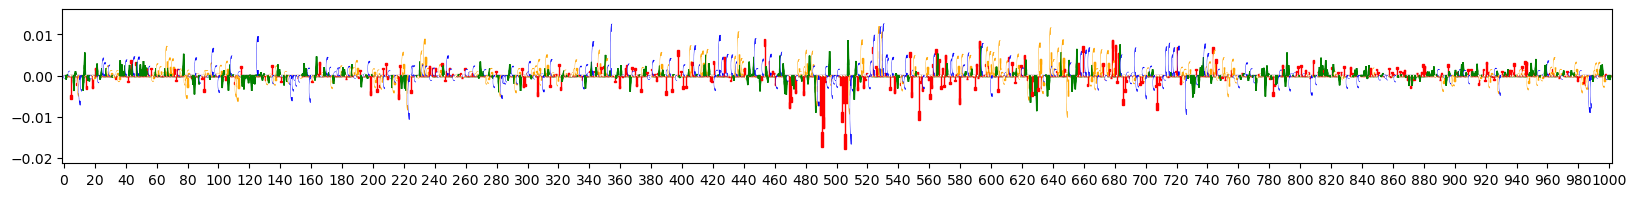

S2_cardiac_log2: 4.19
Pred act: 4.74
Actual contribution scores


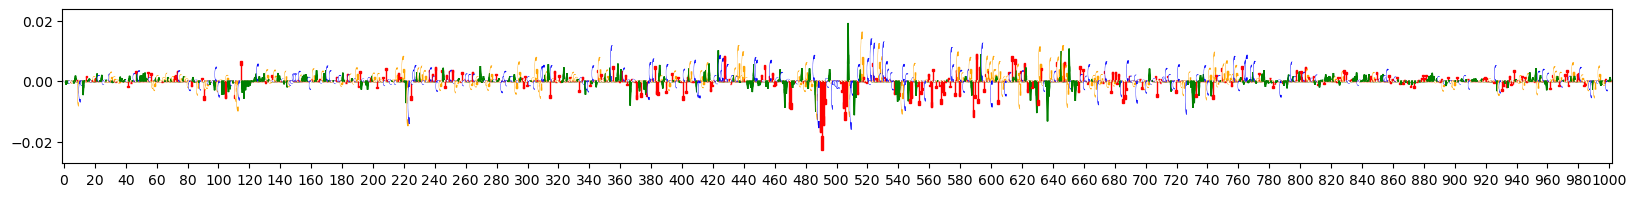

S2_somatic_log2: 6.17
Pred act: 4.54
Actual contribution scores


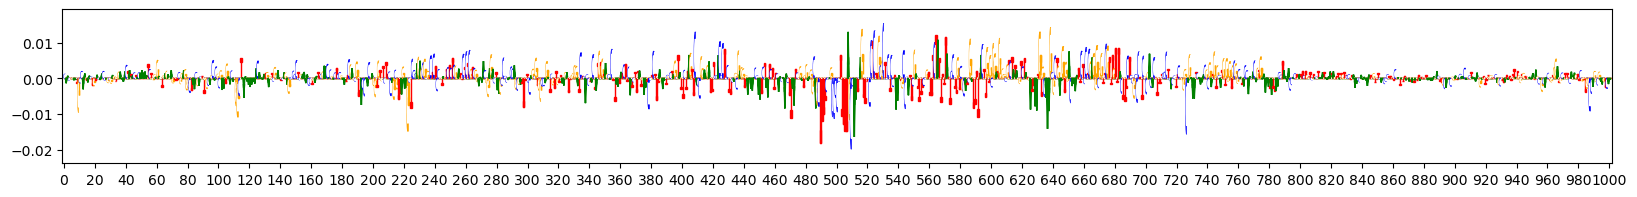

In [18]:
for i in range(1):
    print('name:', slice_cand_test_data.iloc[i]['name'])
    print('S2_mesoderm_log2:', '{0:0.2f}'.format(slice_cand_test_data.iloc[i]['S2_mesoderm_log2']))
    print('Pred act:', '{0:0.2f}'.format(slice_pred_values_mesoderm[i][0]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(slice_final_contr_scores_mesoderm[i], figsize=(20,2), subticks_frequency=20)

    # print('Enhancer:', slice_cand_test_data.iloc[i]['name'])
    print('S2_visceral_log2:', '{0:0.2f}'.format(slice_cand_test_data.iloc[i]['S2_visceral_log2']))
    print('Pred act:', '{0:0.2f}'.format(slice_pred_values_visceral[i][0]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(slice_final_contr_scores_visceral[i], figsize=(20,2), subticks_frequency=20)

    # print('Enhancer:', slice_cand_test_data.iloc[i]['name'])
    print('S2_cardiac_log2:', '{0:0.2f}'.format(slice_cand_test_data.iloc[i]['S2_cardiac_log2']))
    print('Pred act:', '{0:0.2f}'.format(slice_pred_values_cardiac[i][0]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(slice_final_contr_scores_cardiac[i], figsize=(20,2), subticks_frequency=20)

    # print('Enhancer:', slice_cand_test_data.iloc[i]['name'])
    print('S2_somatic_log2:', '{0:0.2f}'.format(slice_cand_test_data.iloc[i]['S2_somatic_log2']))
    print('Pred act:', '{0:0.2f}'.format(slice_pred_values_somatic[i][0]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(slice_final_contr_scores_somatic[i], figsize=(20,2), subticks_frequency=20)